# Visualization of spatial rate maps on tracks

The position of animals running on tracks is often projected to a skeleton of the track (i.e. "linearized"), because often the position *along* the track is the variable of interest and not the distance to the track midline. Generally, such linearization makes further analyses (i.e. characterization of place field properties, decoding, etc.) more straightforward.

It is of course possible to construct a 2D spatial tuning curve for track data. Generally the sampling of position along the width of the track is, however, insufficient and smoothing is required to reduce the variance of the rate estimate. Ideally, one would want to independently control the smoothing along the length and width of the track, but this hard to do for the general case (i.e. curved tracks and tracks with choice points). It should be noted, that the linearization process is basically a way to "average" the rate across the width of the track.

The big advantage of 2D spatial tuning curves is being able to visualize the tuning curve exactly in the shape of the track (as seen from the overhead camera). For linearized position data on a track, visualization is generally performed in 1D. However, this is much less intuitive to map back to the original 2D layout of the track, especially for tracks with choice points (which have discontinuities in linearized space).

In this notebook we will explore different ways of visualizing linearized spatial tuning curves in the original 2D space.

## Imports

In [1]:
import itertools

import numpy as np
import scipy.stats
import scipy.interpolate

import matplotlib.pyplot as plt
import matplotlib.cm
import matplotlib.transforms

%matplotlib inline

import fklab.geometry.shapes

## Utilities

In [2]:
def plot_track(track, axes=None, **kwargs):
    """Convenience track plotting function
    
    Parameters
    ----------
    track : fklab.geometry.shapes.path
    axes : Axes
    **kwargs :
        Extra keyword arguments for `plot` function
    
    Returns
    -------
    Axes
    
    """
    
    if axes is None:
        axes = plt.gca()
    
    if isinstance(track, fklab.geometry.shapes.graph):
        xy = [x.samplepath() for x in track._polylines]
        [axes.plot(x[:,0], x[:,1], **kwargs) for x in xy]
    else:
        xy = curved_track.samplepath()
        axes.plot(xy[:,0], xy[:,1], **kwargs)
    
    return axes

In [3]:
def track2map(track, resolution=1., expand=1.4):
    """Construct an map of distances along/to a track
    
    Parameters
    ----------
    track : fklab.geometry.shapes.path
    resolution : scalar
        size of each point in the map
    expand : scalar
        Factor by which the scale the bounding box of the track
    
    Returns
    -------
    L, D : 2d array
        Maps of linearized position along the track (L) and distance to
        the track (D) for every point in the map.
    x, y : 1d array
        Coordinates for each point in the map.
    
    """
    
    nx, ny = np.ceil(track.boundingbox.size[[0,-1]] * 1.4 / resolution)
    cx, cy = track.boundingbox.center
    
    vx = (np.arange(nx)-(nx-1)/2)*resolution+cx
    vy = (np.arange(ny)-(ny-1)/2)*resolution+cy
    mx, my = np.meshgrid(vx, vy)
    
    L,D,_,_ = track.point2path(np.column_stack([mx.ravel(), my.ravel()]))
    L = np.reshape(L, mx.shape)
    D = np.reshape(D, mx.shape)
    
    return L,D, (vx, vy)

In [4]:
def enhanced_scatter(*args, rotations=None, alphas=None, axes=None, **kwargs):
    """Scatter plot that supports varying rotation and alpha for each marker.
    
    Parameters
    ----------
    *args, **kwargs : 
        Arguments for the matplotlib `scatter` function
    rotations : scalar or 1d array-like
        Marker rotations.
    alphas : scalar or 1d array-like
        Marker alpha values
    
    Returns
    -------
    PathCollection
    
    """
    
    if axes is None:
        axes = plt.gca()
    
    h = axes.scatter(*args, **kwargs)
    
    if not rotations is None:
        rotations = np.ravel(rotations)
        
        paths = h.get_paths()
        
        if len(paths)==1:
            paths = [p.transformed(matplotlib.transforms.Affine2D().rotate(phi)) 
                     for p, phi in zip(itertools.cycle(paths),rotations)]
        else:
            paths = [p.transformed(matplotlib.transforms.Affine2D().rotate(phi)) 
                     for p, phi in zip(paths,itertools.cycle(rotations))]
        
        h.set_paths(paths)
        
    if not alphas is None:
        alphas = np.ravel(alphas)
        
        fc = h.get_facecolors()
        
        if len(fc)>0:
            alphas_ = alphas
            if len(fc)==1:
                fc = np.broadcast_to(fc,(len(alphas),4)).copy()
            elif len(alphas)==1:
                alphas_ = np.broadcast_to(alphas,len(fc))

            fc[:,3] *= alphas_

            h.set_facecolors(fc)
        
        ec = h.get_edgecolors()
        
        if len(ec)>0:
            alphas_ = alphas
            if len(ec)==1:
                ec = np.broadcast_to(ec,(len(alphas),4)).copy()
            elif len(alphas)==1:
                alphas_ = np.broadcast_to(alphas,len(ec))

            ec[:,3] *= alphas_

            h.set_facecolors(ec)

    return h

## Define tracks

In [5]:
# curved track
curved_track = fklab.geometry.shapes.polyline([[50,50],[50,100],[150,100],[150,50]])

# y-maze
edges = [[[100,50],[100,100]], [[100,100],[50,150]], [[100,100],[150,150]]]
edges = [fklab.geometry.shapes.polyline(x) for x in edges]
ymaze = fklab.geometry.shapes.graph(edges, nodes=[[100,50],[100,100],[50,150],[150,150]])

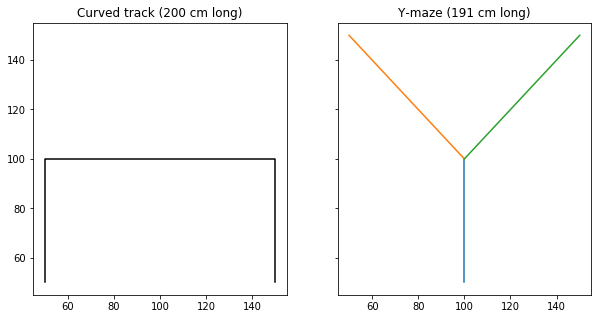

In [6]:
fig,axes = plt.subplots(1, 2, sharex=True, sharey=True, figsize=(10,5))

plot_track(curved_track, axes=axes[0], color='k')
axes[0].set(title='Curved track ({:.0f} cm long)'.format(curved_track.pathlength))

plot_track(ymaze, axes=axes[1])
axes[1].set(title='Y-maze ({:.0f} cm long)'.format(ymaze.pathlength));

## Construct test data for plotting

### Curved track

In [7]:
# let's bin the track
bins, nbins, binsize = curved_track.bin(binsize=5)

# compute bin centers
bincenters = (bins[:-1] + bins[1:])/2.

data_curved_track = dict(
    bins = bins,
    nbins = nbins,
    binsize = binsize,
    bincenters = bincenters,
    track = curved_track,
    label = 'Curved track'
)

# generate two "rate maps" with the following parameters
fieldcenter = [70,90]
fieldsize = [60,50]
peakrate = [10,5]
noise = [0.5,0.5]

for k in [0,1]:
    
    rate = peakrate[k] * (scipy.stats.norm.pdf(bincenters, loc=fieldcenter[k], scale=fieldsize[k]/4) / 
                       scipy.stats.norm.pdf(fieldcenter[k], loc=fieldcenter[k], scale=fieldsize[k]/4))
    rate = rate + np.random.rayleigh(scale=noise[k], size=int(nbins))
    
    data_curved_track['rate' if k==0 else 'rate2'] = rate

### Y-maze

In [8]:
# let's bin the track
bins, nbins, binsize = ymaze.bin(binsize=5, separate=True)

# compute bin centers
bincenters = (bins[:-1] + bins[1:])/2.

data_ymaze = dict(
    bins = bins,
    nbins = nbins,
    binsize = binsize,
    bincenters = bincenters,
    track = ymaze,
    label = 'Y-maze'
)

# generate two "rate maps" with the following parameters
fieldcenter = [110, 40]
fieldsize = [150, 70]
peakrate = [10, 10]
noise = [0.5,0.5]

for k in [0,1]:
    distance = np.abs(ymaze.distance(np.full(bincenters.shape,fieldcenter[k]), bincenters))

    rate = peakrate[k] * (scipy.stats.norm.pdf(distance, loc=0, scale=fieldsize[k]/4) / 
                          scipy.stats.norm.pdf(0, loc=0, scale=fieldsize[k]/4))
    rate = rate + np.random.rayleigh(scale=noise[k], size=int(np.sum(nbins)))
    
    data_ymaze['rate' if k==0else 'rate2'] = rate

## Plots in 1D

### Area plot

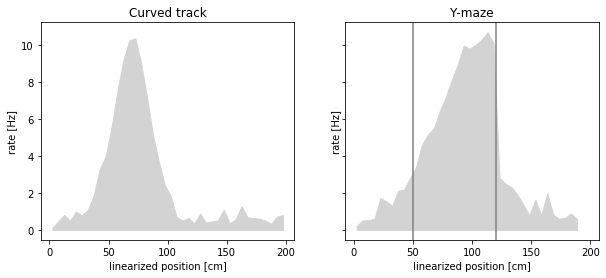

In [9]:
fig, axes = plt.subplots(1, 2, sharex=True, sharey=True, figsize=(10,4))

# areaplot
axes[0].fill_between(data_curved_track['bincenters'],
                     data_curved_track['rate'],
                     color='lightgray')
axes[0].set(title="Curved track", xlabel='linearized position [cm]', ylabel='rate [Hz]')

axes[1].fill_between(data_ymaze['bincenters'],
                     data_ymaze['rate'],
                     color='lightgray')

axes[1].set(title="Y-maze", xlabel='linearized position [cm]', ylabel='rate [Hz]')

edgelengths = np.cumsum(data_ymaze['track'].edgelengths)
axes[1].axvline(edgelengths[0], color='gray')
axes[1].axvline(edgelengths[1], color='gray');

### Bar plot

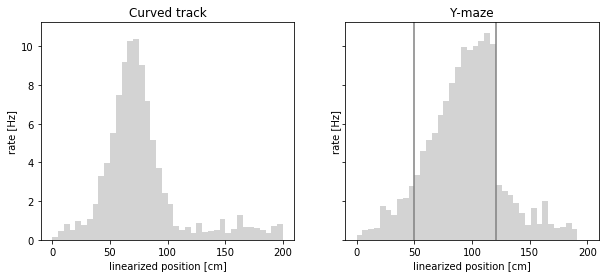

In [10]:
fig, axes = plt.subplots(1, 2, sharex=True, sharey=True, figsize=(10,4))

# areaplot
axes[0].bar(data_curved_track['bincenters'],
            data_curved_track['rate'],
            width=np.repeat(data_curved_track['binsize'], data_curved_track['nbins']),
            color='lightgray')
axes[0].set(title="Curved track", xlabel='linearized position [cm]', ylabel='rate [Hz]')

axes[1].bar(data_ymaze['bincenters'],
            data_ymaze['rate'],
            width=np.repeat(data_ymaze['binsize'], data_ymaze['nbins']),
            color='lightgray')

axes[1].set(title="Y-maze", xlabel='linearized position [cm]', ylabel='rate [Hz]')

edgelengths = np.cumsum(data_ymaze['track'].edgelengths)
axes[1].axvline(edgelengths[0], color='gray')
axes[1].axvline(edgelengths[1], color='gray');


## Plots in 2D

### Scatter plot (rate encoded in marker color)

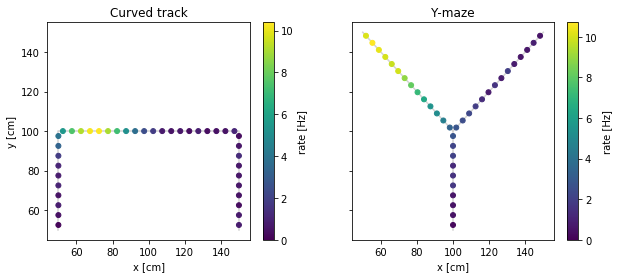

In [11]:
fig, axes = plt.subplots(1, 2, sharex=True, sharey=True, figsize=(10,4))

colormap = 'viridis'
markersize = 25

for ax, data in zip(axes, [data_curved_track, data_ymaze]):
    
    # plot the track in the background
    plot_track(data['track'], axes=ax, color='lightgray')
    
    # convert linearized position to 2D
    bin_xy = data['track'].path2point(data['bincenters'])
    
    h = ax.scatter(bin_xy[:,0], bin_xy[:,1], c=data['rate'], s=markersize,
                   marker='o', vmin=0, zorder=3, cmap=colormap)
    
    # create color bar
    plt.colorbar(h, ax=ax, label='rate [Hz]')
    
axes[0].set(ylabel='y [cm]');
[ax.set(xlabel='x [cm]', title=data['label']) for ax,data in zip(axes, [data_curved_track, data_ymaze])];

### Scatter plot (rate encoded in marker size)

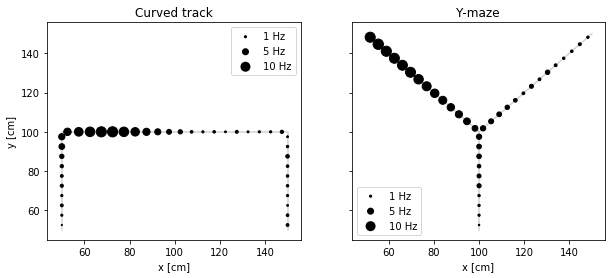

In [12]:
fig, axes = plt.subplots(1, 2, sharex=True, sharey=True, figsize=(10,4))

scale_factor = 10
marker = 'o'

for ax, data in zip(axes, [data_curved_track, data_ymaze]):
    
    # plot the track in the background
    plot_track(data['track'], axes=ax, color='lightgray')
    
    # convert linearized position to 2D
    bin_xy = data['track'].path2point(data['bincenters'])
    
    h = ax.scatter(bin_xy[:,0], bin_xy[:,1], s=scale_factor*data['rate'], 
                   c='k', marker=marker, zorder=3)
    
    
    # we use a legend to show how marker size maps to rate
    # for this we create invisible scatter plots with defined marker size
    # note that we set marker and edgecolors to the same values used above
    legend_rates = [1,5,10]
    h = [
        ax.scatter(
            np.nan, np.nan, s=scale_factor*r,
            c='k', marker=marker, edgecolors='none'
        )
        for r in legend_rates]
    # now we can create a legend for the invisible scatter plots
    ax.legend(h, ['{} Hz'.format(r) for r in legend_rates])
    
    # alternatively, we can try to build the legend automatically
    # using matplotlib's tools
    #handles, labels = h.legend_elements(
    #    prop="sizes", num=4, fmt="{x} Hz", func=lambda x: x/scale_factor)
    #ax.legend(handles, labels)

axes[0].set(ylabel='y [cm]');
[ax.set(xlabel='x [cm]', title=data['label']) for ax,data in zip(axes, [data_curved_track, data_ymaze])];

### Scatter plot (rate encoded in marker color and size)

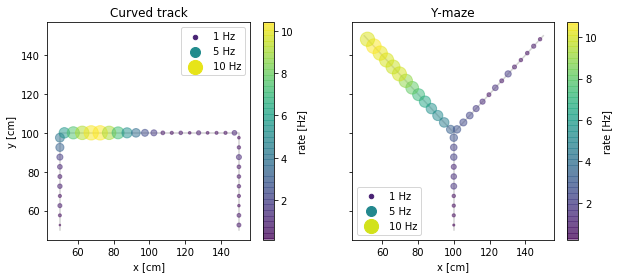

In [14]:
fig, axes = plt.subplots(1, 2, sharex=True, sharey=True, figsize=(10,4))

colormap = 'viridis'
scale_factor = 20
marker = 'o'

cm = matplotlib.cm.get_cmap(colormap)

for ax, data in zip(axes, [data_curved_track, data_ymaze]):
    
    # plot the track in the background
    plot_track(data['track'], axes=ax, color='lightgray')
    
    # convert linearized position to 2D
    bin_xy = data['track'].path2point(data['bincenters'])
    
    h = ax.scatter(bin_xy[:,0], bin_xy[:,1], s=scale_factor*data['rate'], 
                   c=data['rate'], marker=marker, zorder=3, alpha=0.5, cmap=colormap)
    
    
    # create colorbar
    plt.colorbar(h, ax=ax, label='rate [Hz]')
    
    # we could also use a legend to show how marker size/color maps to rate
    # for this we create invisible scatter plots with defined marker size/color
    legend_rates = [1,5,10]
    h = [
        ax.scatter(
            np.nan, np.nan, s=scale_factor*r,
            c=[cm(r/np.max(data['rate']))], marker=marker
        )
        for r in legend_rates]
    # now we can create a legend for the invisible scatter plots
    ax.legend(h, ['{} Hz'.format(r) for r in legend_rates])
    
axes[0].set(ylabel='y [cm]');
[ax.set(xlabel='x [cm]', title=data['label']) for ax,data in zip(axes, [data_curved_track, data_ymaze])];    

### Image

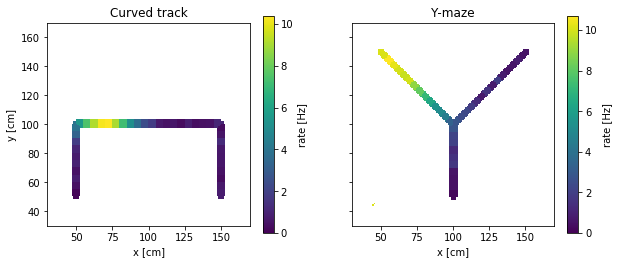

In [15]:
fig, axes = plt.subplots(1, 2, sharex=True, sharey=True, figsize=(10,4))

cmap = 'viridis'
resolution = 1
width = 5

for ax, data in zip(axes, [data_curved_track, data_ymaze]):
    
    # compute distance along track and distance to track for a grid of points
    L, D, (x, y) = track2map(data['track'], resolution=resolution)
    
    # convert distance along track to rate
    # but only for points close to the track
    valid = np.logical_and(-width/2<=D, D<=width/2)
    M = np.full(L.shape, np.nan)
    M[valid] = scipy.interpolate.interp1d(
        data['bincenters'], data['rate'], kind='nearest',
        bounds_error=False, fill_value='extrapolate')(L[valid])
    
    # compute the extent of the map
    # the x and y vectors represent the pixel centers
    # so we have to shift these values by half a pixel size to get the extent
    extent = np.array([x[0], x[-1], y[0], y[-1]]) + np.array([-1,1,-1,1])*0.5*resolution
    
    # finally, show the image
    # we force the lowest rate shown to zero
    h = ax.imshow(M, extent=extent, origin='lower', vmin=0, cmap=cmap)
    
    # create colorbar
    plt.colorbar(h, ax=ax, label='rate [Hz]')

axes[0].set(ylabel='y [cm]');
[ax.set(xlabel='x [cm]', title=data['label']) for ax,data in zip(axes, [data_curved_track, data_ymaze])];

### Image (dual direction rate map)

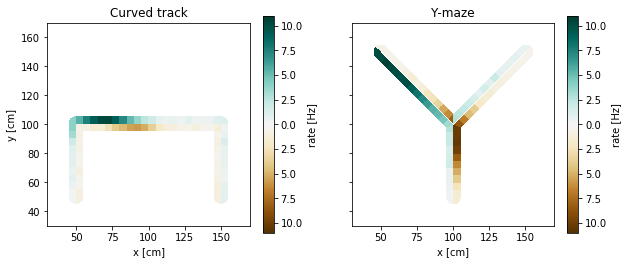

In [16]:
fig, axes = plt.subplots(1, 2, sharex=True, sharey=True, figsize=(10,4))

# since below we map rate of the two rate maps to different colors
# (by using negative rates for the second rate map)
# we need to specify a diverging colormap here
cmap = 'BrBG'

resolution = 0.5
width = 10

for ax, data in zip(axes, [data_curved_track, data_ymaze]):
    
    # compute distance along track and distance to track for a grid of points
    L, D, (vx, vy) = track2map(data['track'], resolution=resolution)
    
    # convert distance along track to rate
    # but only for points close to the track
    M = np.full(L.shape, np.nan)
    
    # on one side of the track we will plot one rate map
    valid = np.logical_and(D>0,D<=width/2)
    M[valid] = scipy.interpolate.interp1d(
        data['bincenters'], data['rate'], kind='nearest',
        bounds_error=False, fill_value='extrapolate')(L[valid])
    
    # and on the other side the second rate map
    # note that we use negative rate, so that they get mapped to different colors
    # (we could have used positive rate, and used the same color mapping
    #  for both rate maps)
    valid = np.logical_and(D<0,D>=-width/2)
    M[valid] = scipy.interpolate.interp1d(
        data['bincenters'], -data['rate2'], kind='nearest',
        bounds_error=False, fill_value='extrapolate')(L[valid])
    
    # compute the extent of the map
    # the x and y vectors represent the pixel centers
    # so we have to shift these values by half a pixel size to get the extent
    extent = np.array([vx[0], vx[-1], vy[0], vy[-1]]) + np.array([-1,1,-1,1])*0.5*resolution
    
    # finally, show the image
    # note that we set the minimum and maximum to the same
    # value (although with opposite sign)
    h = ax.imshow(M, extent=extent, origin='lower', vmin=-11, vmax=11, cmap=cmap)
    
    # create colorbar
    cbar = plt.colorbar(h, ax=ax, label='rate [Hz]')
    # we have to fix the negatively values ticks
    ticks = np.abs(cbar.get_ticks())
    cbar.ax.set_yticklabels(ticks)

axes[0].set(ylabel='y [cm]');
[ax.set(xlabel='x [cm]', title=data['label']) for ax,data in zip(axes, [data_curved_track, data_ymaze])];

### Enhanced scatter plot (rotated markers, rate encoded in alpha value)

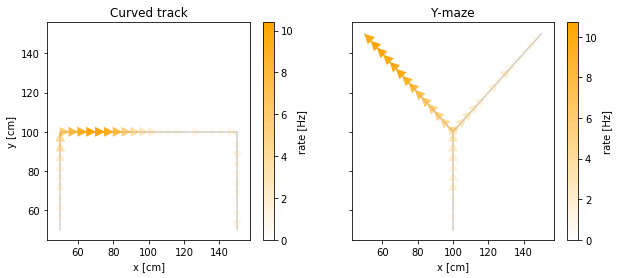

In [17]:
fig, axes = plt.subplots(1, 2, sharex=True, sharey=True, figsize=(10,4))

# we use a single color for all markers
# (if rate is also mapped to a color, given a colormap, then we need to change the way we build the colorbar)
color = 'orange'

# marker size
size = 100

for ax, data in zip(axes, [data_curved_track, data_ymaze]):
    
    #plot the track in the background
    plot_track(data['track'], axes=ax, color='lightgray')
    
    # convert linearized position to 2D
    bin_xy = data['track'].path2point(data['bincenters'])
    # compute tangent angle of track at bin centers
    phi = data['track'].tangent(data['bincenters'])
    
    # scatter plot
    # we use a right-pointing arrow as base marker (when rotation is zero)
    # zorder is set such that the markers are plotted on top of the track line
    h = enhanced_scatter(
        bin_xy[:,0], bin_xy[:,1],
        s=size, c=color, alphas=data['rate']/np.max(data['rate']),
        marker='>', zorder=3,
        rotations=phi, axes=ax, edgecolors='none'
    )
    
    # create colorbar
    # the alpha values are not picked up by the standard way of creating a colorbar
    # here, we create a custom mappable that maps rates to colors
    # since colorbars don't display transparency well, we need to convert
    # transparent colors to their non-transparent color equivalent (assuming a white background)
    
    # let's get the RGBA array of the selected color
    c = np.array(matplotlib.colors.to_rgba(color))
    # we adjust the color values according to transparency
    # and set the alpha value to 1
    c[:3] = 1-c[3]+c[:3]*c[3]
    c[3] = 1 
    # we create a custom colormap that runs from white to the selected color
    cm = matplotlib.colors.LinearSegmentedColormap.from_list('colormap', [(1,1,1,1), c])
    # we create a normalize object that maps our range of rates to [0,1]
    norm = matplotlib.colors.Normalize(vmin=0,vmax=np.max(data['rate']))
    # finally we create a mappable ...
    mappable = matplotlib.cm.ScalarMappable(norm=norm, cmap=cm)
    
    # ... and construct a colorbar
    plt.colorbar(mappable, ax=ax, label='rate [Hz]')

axes[0].set(ylabel='y [cm]');
[ax.set(xlabel='x [cm]', title=data['label']) for ax,data in zip(axes, [data_curved_track, data_ymaze])];

### Enhanced scatter plot (rotated markers, rate encoded in marker size)

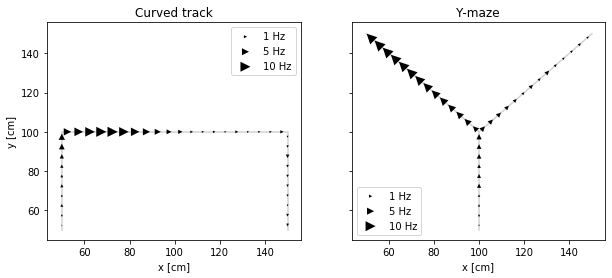

In [18]:
fig, axes = plt.subplots(1, 2, sharex=True, sharey=True, figsize=(10,4))

scale_factor = 10

for ax, data in zip(axes, [data_curved_track, data_ymaze]):
    
    #plot the track in the background
    plot_track(data['track'], axes=ax, color='lightgray')
    
    # convert linearized position to 2D
    bin_xy = data['track'].path2point(data['bincenters'])
    # compute tangent angle of track at bin centers
    phi = data['track'].tangent(data['bincenters'])
    
    # scatter plot
    # we use a right-pointing arrow as base marker (when rotation is zero)
    # zorder is set such that the markers are plotted on top of the track line
    h = enhanced_scatter(
        bin_xy[:,0], bin_xy[:,1],
        s=scale_factor*data['rate'],
        c='k', marker='>', zorder=3,
        rotations=phi, axes=ax, edgecolors='none'
    )
    
    # we use a legend to show how marker size maps to rate
    # for this we create invisible scatter plots with defined marker size
    # note that we set marker and edgecolors to the same values used above
    # and rotation is set to zero so that all legend markerspoint to the right
    legend_rates = [1,5,10]
    h = [
        enhanced_scatter(
            np.nan, np.nan, s=scale_factor*r,
            c='k', axes=ax, rotations=0, marker='>', edgecolors='none'
        )
        for r in legend_rates]
    # now we can create a legend for the invisible scatter plots
    ax.legend(h, ['{} Hz'.format(r) for r in legend_rates])
    
    # alternatively, we can try to build the legend automatically
    # using matplotlib's tools
    #handles, labels = h.legend_elements(
    #    prop="sizes", num=4, fmt="{x} Hz", func=lambda x: x/scale_factor)
    #ax.legend(handles, labels)

axes[0].set(ylabel='y [cm]');
[ax.set(xlabel='x [cm]', title=data['label']) for ax,data in zip(axes, [data_curved_track, data_ymaze])];

### Enhanced scatter plot (rotated markers, two directions)

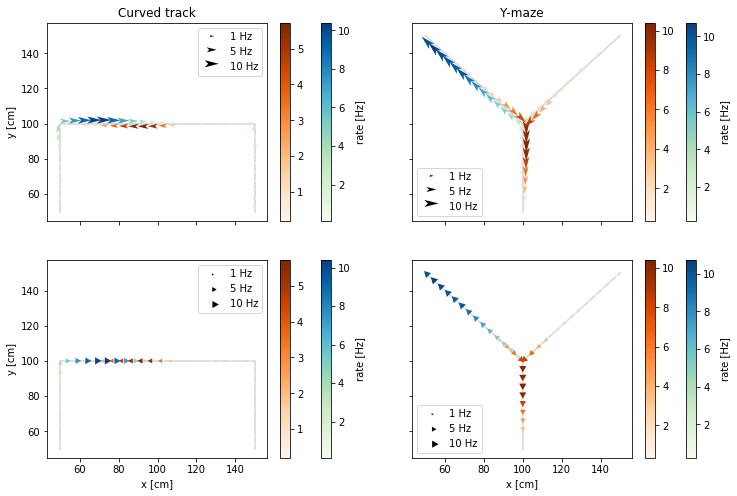

In [19]:
# we define custom marker shapes
# the marker shape should fit within a box centered on (0,0) with a size of 1
# (thus x and y values raneg from -0.5 to +0.5)
markers = [
    # side-by-side arrows
    #[(-0.5,0.5),(0.5,0.25),(-0.5,0),(-0.5,0.5)], # elongated arrow
    #[(-0.25,0.5),(0.25,0.25),(-0.25,0),(-0.25,0.5)], # squarish arrow
    [(-0.5,0.5),(0.5,0.25),(-0.5,0),(-0.25,0.25),(-0.5,0.5)], # elongated arrow with notch

    # back-to-back arrows
    [(0.05,0.25),(0.5,0.),(0.05,-0.25),(0.05,0.25)], # squarish arrow
    #[(0.05,0.5),(0.5,0.),(0.05,-0.5),(0.05,0.5)], # wide arrow
]

# define colormaps for the two rate maps
colormaps = ['GnBu', 'Oranges']
scale_factor = 20  # marker size scale factor

fig, axes = plt.subplots(len(markers), 2, sharex=True, sharey=True, figsize=(12,4*len(markers)))

for row, marker in zip(axes, markers):

    for ax, data in zip(row, [data_curved_track, data_ymaze]):
        
        # plot the track in the background
        plot_track(data['track'], axes=ax, color='lightgray')

        # convert linearized position to 2D
        bin_xy = data['track'].path2point(data['bincenters'])
        # compute tangent angle of track at bin centers
        phi = data['track'].tangent(data['bincenters'])
        
        # scatter plot for first rate map
        # note that we map rate to marker scale, marker size and marker rotation
        h = enhanced_scatter(bin_xy[:,0], bin_xy[:,1],
                             s=scale_factor*data['rate'], 
                             c=data['rate'],
                             marker=marker, zorder=3, cmap=colormaps[0],
                             rotations=phi, axes=ax, edgecolors='none'
        )
        
        # create colorbar for first rate map
        plt.colorbar(h, ax=ax, label='rate [Hz]', fraction=0.1)
        
        # scatter plot for second rate map
        # note that we map rate to marker scale, marker size and marker rotation
        # note also that we additionaly rotate markers to point in the opposite direction
        h = enhanced_scatter(bin_xy[:,0], bin_xy[:,1],
                             s=scale_factor*data['rate2'], 
                             c=data['rate2'],
                             marker=marker, zorder=3, cmap=colormaps[1],
                             rotations=phi+np.pi, axes=ax, edgecolors='none'
        )
        
        # create colorbar for second rate map
        plt.colorbar(h, ax=ax, fraction=0.1)
        
        # we use a legend to show how marker size maps to rate
        # for this we create invisible scatter plots with defined marker size
        # note that we set marker and edgecolors to the same values used above
        # and rotation is set to zero so that all legend markerspoint to the right
        legend_rates = [1,5,10]
        h = [
            enhanced_scatter(
                np.nan, np.nan, s=scale_factor*r,
                c='k', marker=marker, axes=ax, rotations=0, edgecolors='none'
            )
            for r in legend_rates]
        # now we can create a legend for the invisible scatter plots
        ax.legend(h, ['{} Hz'.format(r) for r in legend_rates])
        
        
[ax.set(ylabel='y [cm]') for ax in axes[:,0]];
[ax.set(xlabel='x [cm]') for ax in axes[-1,:]];
[ax.set(title=data['label']) for ax,data in zip(axes[0,:], [data_curved_track, data_ymaze])];